# FIFA Dataset (Deep Neural Network)

I will be experimenting this time with a deep neural network using Keras with the FIFA Dateset. The aim is to predict the best salary to offer a player based on their statistics. Ideally, I would like to remove the overall rating as well so that we're only focused on the basic attributes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Normalization
from keras.optimizers import Adam

csv_location = r"F:\Users\harri\Documents\Ryan\Machine_Learning\FIFA_2022\dataset\players_22.csv"
pd.set_option("display.max_columns", None)

# Extract the csv data into a Pandas dataframe
fifa_df = pd.read_csv(csv_location, index_col=0, low_memory=False)
print(fifa_df.shape[0])
fifa_df.head()

19239


,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.so

### Cleaning Data

In [2]:
# Split goalkeepers from outfield players as they have specific attributes that don't cross over.
# They will also have lower stats in other areas, making them outliers.
fifa_df = fifa_df[fifa_df["club_position"] != "GK"]

# Remove the url rows as these aren't particularly useful.
fifa_df.drop(["player_url", "player_face_url", "club_logo_url", 
              "nation_logo_url", "nation_flag_url", "club_flag_url"], inplace=True, axis=1)

# Remove other unused columns
fifa_df.drop(["short_name", "long_name", "real_face", "club_loaned_from", 
              "club_joined", "club_contract_valid_until", 
              "nationality_name", "nation_team_id", "nation_jersey_number", "dob",
              "player_tags", "player_traits", "club_jersey_number", "release_clause_eur",
              "club_name", "league_level"], inplace=True, axis=1)

# Remove positional and goalkeeping columns.
fifa_df = fifa_df.iloc[:, :-33]

# Drop players with missing wage data.
fifa_df.dropna(how="any", inplace=True, subset=["wage_eur"])
fifa_df = fifa_df.loc[(fifa_df[["wage_eur"]] != 0).all(axis=1)]

# Display
print(fifa_df.shape[0])
fifa_df.head()

18477


,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_name,club_position,nationality_id,nation_position,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,"RW, ST, CF",93,93,78000000.0,320000.0,34,170,72,73.0,French Ligue 1,RW,52,RW,Left,4,4,5,Medium/Low,Unique,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24
188545,ST,92,92,119500000.0,270000.0,32,185,81,21.0,German 1. Bundesliga,ST,37,RS,Right,4,4,5,High/Medium,Unique,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19
20801,"ST, LW",91,91,45000000.0,270000.0,36,187,83,11.0,English Premier League,ST,38,ST,Right,4,5,5,High/Low,Unique,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24
190871,"LW, CAM",91,91,129000000.0,270000.0,29,175,68,73.0,French Ligue 1,LW,54,NaN,Right,5,5,5,High/Medium,Unique,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29
192985,"CM, CAM",91,91,125500000.0,350000.0,30,181,70,10.0,English Premier League,RCM,7,RCM,Right,5,4,4,High/High,Unique,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53


### Data at a Glance

We can see that most features are reasonably well spread, with a few outliers in the wage, value and international reputation.

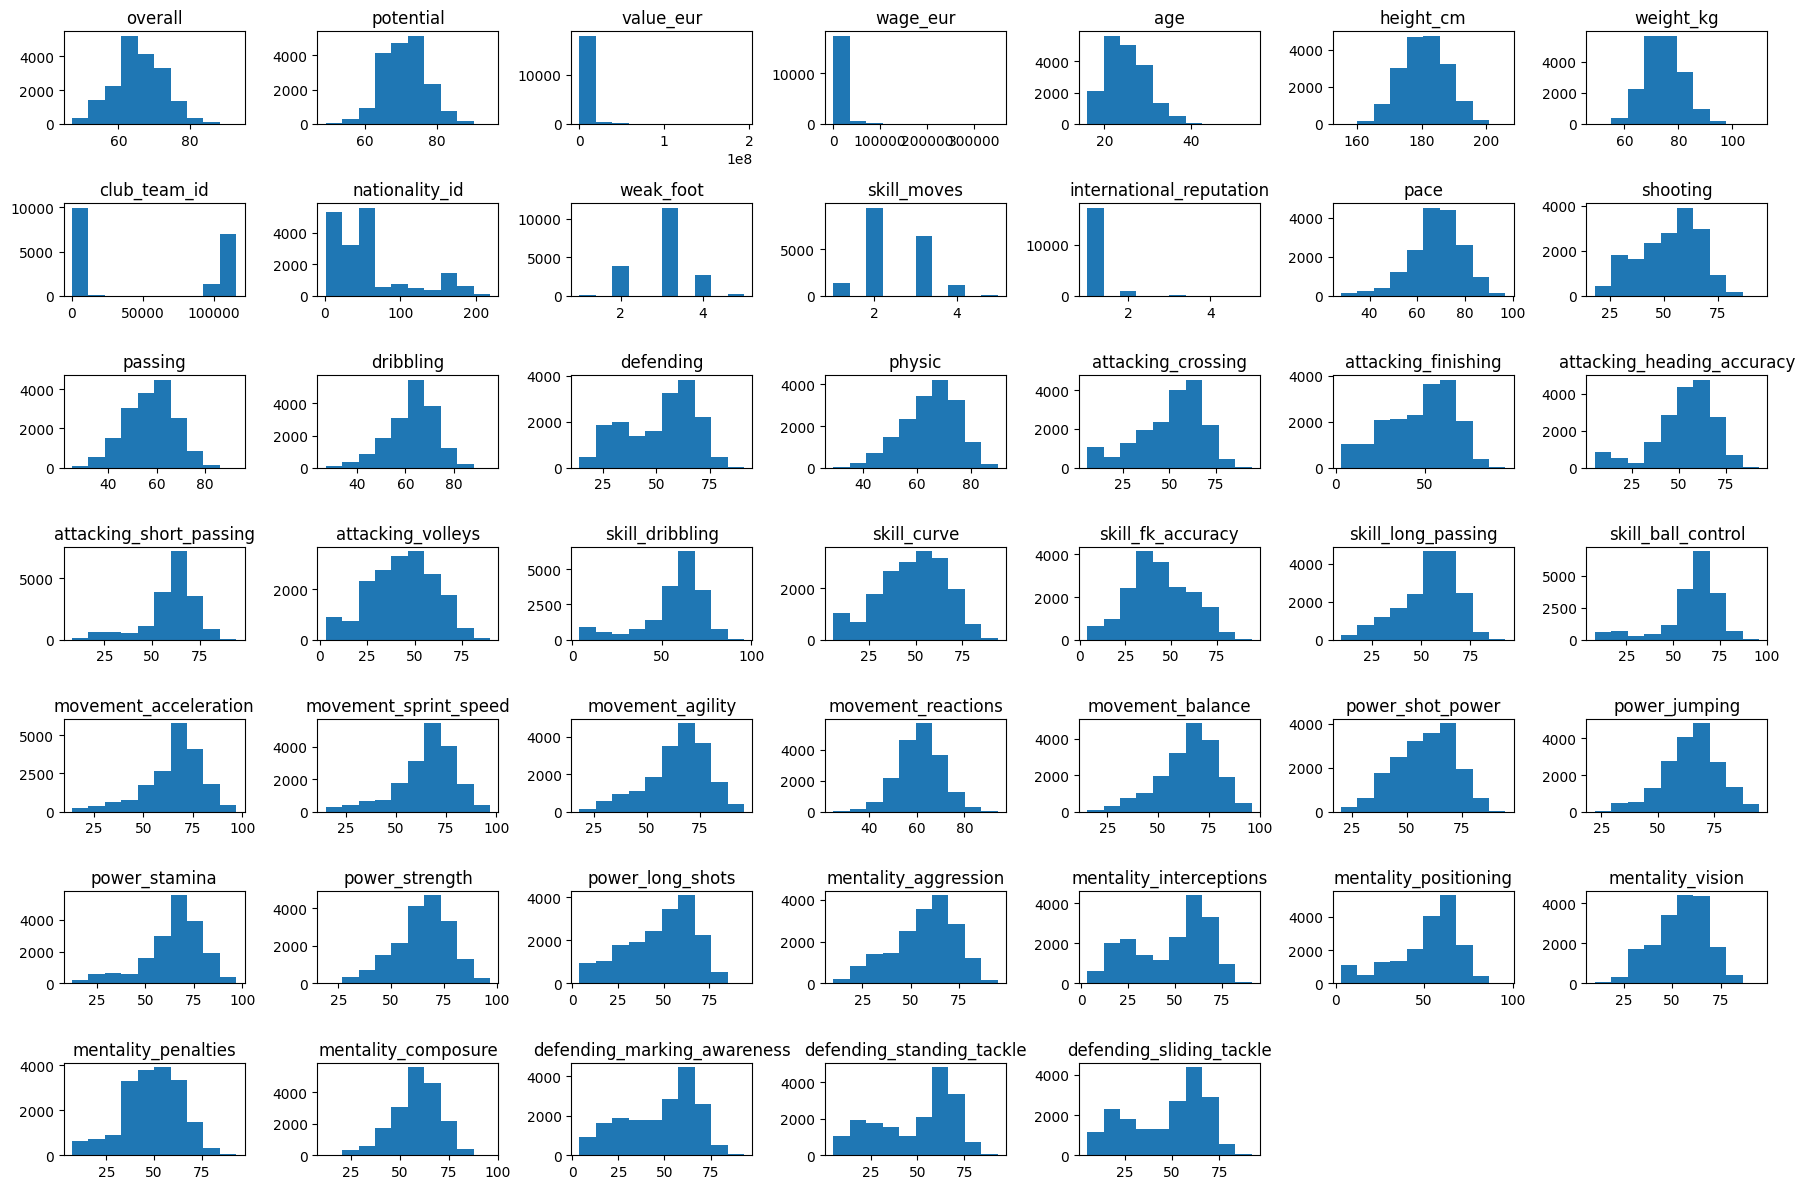

In [3]:
histograms = fifa_df.hist(grid=False, figsize=(18, 12))
plt.tight_layout()
plt.show()

Here we can see that the wage spread is quite low, with an upwards trend as their overall rating improves.

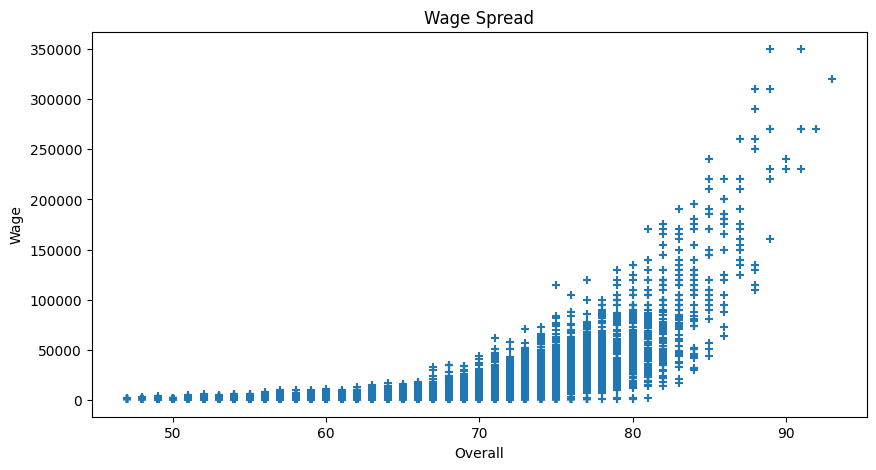

In [4]:
# Plot wage/ salary data to a graph
plt.figure(figsize=(10, 5))
plt.scatter(fifa_df["overall"], fifa_df["wage_eur"], marker="+")
plt.title("Wage Spread")
plt.xlabel("Overall")
plt.ylabel("Wage")
plt.show()

### Fix Club Positions

This gives us an idea of the club position feature. We can see that the vast majority of players are substitutes and reserves. I don't really like this skew as I would prefer to know their preferred position to get the hidden value in players.

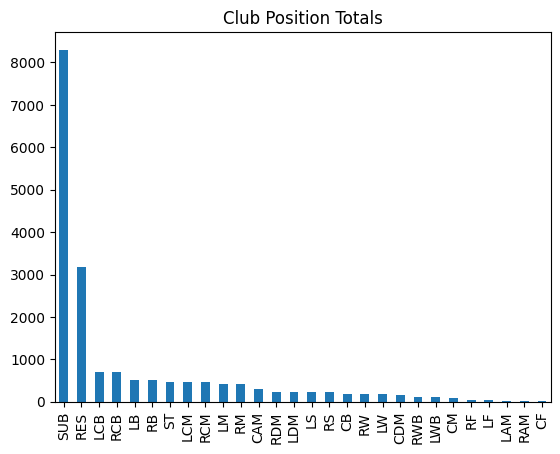

In [5]:
# Extract the data we need.
fifa_df["club_position"].value_counts().plot.bar(title="Club Position Totals")
plt.show()

To rectify this, I will use the first position of the "player_position" column, which lists their preferred positions. As this has multiple, I will use their first preferred position and negate the rest.

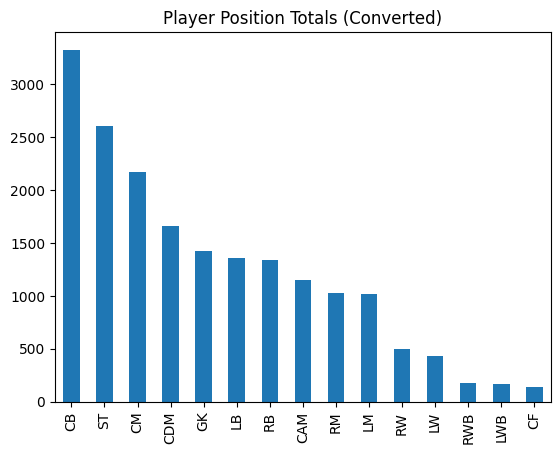

In [6]:
# Convert the player positions column.
fifa_df["player_positions"] = fifa_df["player_positions"].str.split(",").str[0]

# Extract the data we need.
fifa_df["player_positions"].value_counts().plot.bar(title="Player Position Totals (Converted)")
plt.show()

### Convert String Data

Convert the text-based data to numerical for better computation in the model later.

In [7]:
# Convert text-based data to numerical
def convert_to_numerical_dict(input_list):
    """
    Will convert a list of unique values and return a dictionary with numerical values.
    :param input_list: List of unique strings.
    :return: Tuple of 2 Dicts of unique strings mapped to numerical values and a way to convert them back.
    """
    output_dict = {i: x for x, i in enumerate(input_list)}
    converter_dict = {x: i for x, i in enumerate(input_list)}
    return output_dict, converter_dict

convert_dicts = {}

# Fix simpler columns with numerical values mapped from strings.
for each_column in ["preferred_foot", "league_name", "club_position", 
                    "body_type", "nation_position", "work_rate", "player_positions"]:
    # Get all unique items to convert to keys.
    unique_values = fifa_df[each_column].unique()
    
    # Convert to a dict of numbers to labels converted.
    mapped_values, converter_values = convert_to_numerical_dict(input_list=unique_values)
    
    # Add the converters to a dict so we can convert numerical values back when needed.
    convert_dicts[each_column] = converter_values
    
    # Now convert the text to their numerical values in the dataframe.
    fifa_df[each_column] = fifa_df[each_column].map(mapped_values)

# Remove any final N/A values to avoid the Normalizer failing later..
fifa_df.dropna(inplace=True)
    
# Display
fifa_df.head()

,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_name,club_position,nationality_id,nation_position,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,0,93,93,78000000.0,320000.0,34,170,72,73.0,0,0,52,0,0,4,4,5,0,0,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24
188545,1,92,92,119500000.0,270000.0,32,185,81,21.0,1,1,37,1,1,4,4,5,1,0,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19
20801,1,91,91,45000000.0,270000.0,36,187,83,11.0,2,1,38,2,1,4,5,5,2,0,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24
190871,2,91,91,129000000.0,270000.0,29,175,68,73.0,0,2,54,3,1,5,5,5,1,0,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29
192985,3,91,91,125500000.0,350000.0,30,181,70,10.0,2,3,7,4,1,5,4,4,3,0,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53


## Build Models

In [8]:
# Define X and Y 
# Features
X = np.array(fifa_df.loc[:, fifa_df.columns != "wage_eur"].values)
X = X.reshape(-1, len(fifa_df.columns) - 1)

# Labels
y = np.array(fifa_df.wage_eur.values)
y = y.reshape(-1, 1)
print(X.shape, y.shape)

(17041, 53) (17041, 1)


In [9]:
# Split into training, test and development sets.
# Training 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, shuffle=True)
print(X_train, y_train)

[[ 1. 69. 70. ... 20. 22. 25.]
 [11. 70. 70. ... 65. 67. 68.]
 [ 7. 63. 63. ... 71. 64. 62.]
 ...
 [14. 51. 69. ... 40. 48. 52.]
 [ 7. 63. 70. ... 66. 65. 64.]
 [ 3. 66. 71. ... 58. 56. 53.]] [[ 8000.]
 [ 7000.]
 [  500.]
 ...
 [  600.]
 [11000.]
 [ 3000.]]


In [10]:
# Normalise the data
X_normalizer = Normalization(axis=-1)
X_normalizer.adapt(X_train)

# Build the model
model = Sequential([
  X_normalizer,
  Dense(64, activation="relu"),
  Dense(64, activation="relu"),
  Dense(1)
])

# Compile the model.
model.compile(loss="mean_absolute_error",
              optimizer=Adam(0.001),
              metrics="accuracy")

# Display.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 53)               107       
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                3456      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,788
Trainable params: 7,681
Non-trainable params: 107
_________________________________________________________________


In [11]:
# Now train the model.
history = model.fit(X_train, y_train,
                    verbose=0, epochs=100, batch_size=10,
                    validation_data=(X_test, y_test))


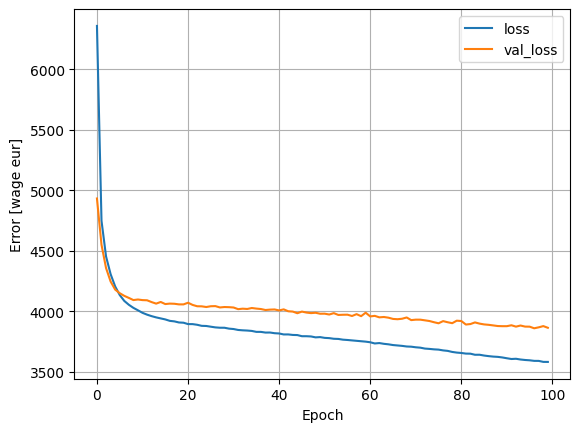

In [12]:
# Plot the loss to a graph
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Error [wage eur]")
plt.legend()
plt.grid(True)

107/107 [==============================] - 0s 585us/step


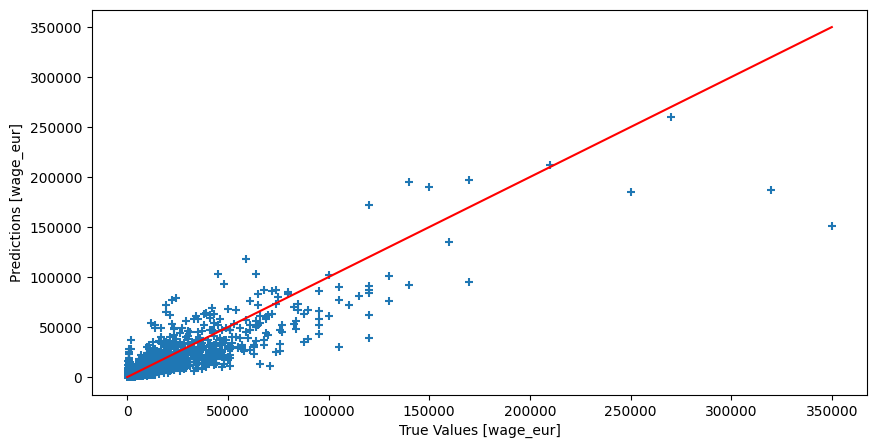

In [13]:
# Make some predictions based on our test data.
test_predictions = model.predict(X_test).flatten()
a = plt.figure(figsize=(10, 5))
plt.scatter(y_test, test_predictions, marker="+")
plt.xlabel("True Values [wage_eur]")
plt.ylabel("Predictions [wage_eur]")
highest_label = max(map(max, y_test))
lims = [0, highest_label]
plt.plot(lims, lims, color="red")
plt.show()

The line fits the data quite well. Let's take one random player, input their stats and see what the wage prediction is.

In [14]:
random_player = fifa_df.iloc[[2324]]

# Convert the df temporarily to display
temp_random_player = random_player.copy()

# Now convert the text to their numerical values in the dataframe.
for column_name, column_map in convert_dicts.items():
    temp_random_player[column_name] = temp_random_player[column_name].map(column_map)

temp_random_player.head()

,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_name,club_position,nationality_id,nation_position,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
sofifa_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
205943,CB,73,73,2100000.0,23000.0,31,184,75,111974.0,Italian Serie A,LCB,39,RCB,Right,3,2,2,Medium/Medium,Lean (170-185),56.0,62.0,56.0,62.0,75.0,66.0,46,56,73,68,70,59,46,25,70,65,53,59,56,72,66,75,69,56,68,69,75,76,36,46,51,67,76,75,73


In [15]:
player_input_data = np.array(random_player.loc[:, random_player.columns != "wage_eur"].values)
player_prediction = model.predict(player_input_data, verbose=0)
print(player_prediction[0][0])

17030.338


We can see that it should be around 23,000 and we got 17,030.338